In [1]:
! pip install transformers
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import transformers
from transformers import BertTokenizer,BertModel,AdamW,get_linear_schedule_with_warmup
import tqdm.auto as tqdm
import torch.nn.functional as F
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score,f1_score,roc_curve
from torch import nn,optim
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from textwrap import wrap

import matplotlib.pyplot as plt
from matplotlib import font_manager

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 4
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')
!wget https://www.easynepalityping.com/resource/font/bangla/06-nikosh-bangla-font.zip
!unzip 06-nikosh-bangla-font.zip

--2023-12-06 05:26:54--  https://www.easynepalityping.com/resource/font/bangla/06-nikosh-bangla-font.zip
Resolving www.easynepalityping.com (www.easynepalityping.com)... 172.67.165.83, 104.21.11.66, 2606:4700:3035::ac43:a553, ...
Connecting to www.easynepalityping.com (www.easynepalityping.com)|172.67.165.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317905 (310K) [application/zip]
Saving to: ‘06-nikosh-bangla-font.zip.5’

06-nikosh-bangla-fo 100%[===================>] 310.45K  --.-KB/s    in 0.02s   

2023-12-06 05:26:54 (12.2 MB/s) - ‘06-nikosh-bangla-font.zip.5’ saved [317905/317905]

Archive:  06-nikosh-bangla-font.zip
replace Nikosh.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/BAT sentiment analysis/predicted_unsupervised_sentiment.xlsx")
df.sample(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,sentence,sentiment
2929,2929,NaN,NaN,পরবা কোড করবা,0
217,217,NaN,NaN,গিলমটস পাথীদের উড়ে চলার মনোরম দৃশ্য,1
3213,3213,NaN,NaN,এখন কার মেয়েরা তু পায়ে কাছা কাছি যেতে চায় না অ...,0
5571,5571,NaN,NaN,আপরাধী ধরেয় কোন বিচার হয়েতেছে আর আপরাধী খুজতে ...,0
1543,1543,NaN,NaN,আজকাল স্বল্প প্রশিক্ষন আর অভিজ্ঞতা নিয়েই হিমল...,1
247,247,NaN,NaN,হারামির বাচ্চা তোর জন্ম মনে হয় কুকুর দিয়াছে,0
1436,1436,NaN,NaN,অামার মন‌ে হয় রাজ্জাকক‌ে নেয়া জরুরী,0
230,230,NaN,NaN,আমার কিছু একটিভ ও লাইকার বন্ধু চাই থাকলে সাড়া ...,1
1499,1499,NaN,NaN,কখনো কারো উপকার না করতে পাললে ও ক্ষতিকরা উচিত না,0
4447,4447,NaN,NaN,অভিনন্দন মুস্তাফিজ,1


In [4]:
#check the rows and columns number.
print(f"number of rows:--> {df.shape[0]} and number of columns:--> {df.shape[1]}")

number of rows:--> 6652 and number of columns:--> 5


In [5]:
#check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6652 entries, 0 to 6651
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6652 non-null   int64  
 1   Unnamed: 1  0 non-null      float64
 2   Unnamed: 2  0 non-null      float64
 3   sentence    6652 non-null   object 
 4   sentiment   6652 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 260.0+ KB


In [6]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
Unnamed: 1,6652,1.0
Unnamed: 2,6652,1.0
Unnamed: 0,0,0.0
sentence,0,0.0
sentiment,0,0.0


In [7]:
# Drop the first three columns
df = df[["sentence","sentiment"]]

In [8]:
#check for missing values
def checking_m(df):
    null_v = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    null_v = pd.concat([null_v, null_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return null_v

checking_m(df)

,Missing_Number,Missing_Percent
sentence,0,0.0
sentiment,0,0.0


In [9]:
#check for dublicated rows
print("Numbers of duplicated rows :",df.duplicated().sum())

Numbers of duplicated rows : 9


In [10]:
#dropping the duplicated rows
df=df.drop_duplicates(keep="first")
print("After removing,now number of duplicated rows are:",df.duplicated().sum())

After removing,now number of duplicated rows are: 0


# EDA and Preprocessing

In [11]:
df.sentiment.value_counts()

0    3612
1    3031
Name: sentiment, dtype: int64

Text(0.5, 0, 'category')

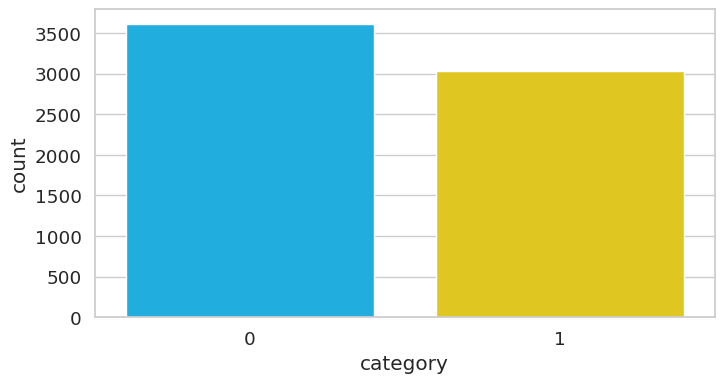

In [12]:
#check for imblanced classes
sns.countplot(data=df,x="sentiment")
plt.xlabel('category')

In [13]:
import re
def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [14]:
df['cleanText'] = df.sentence.apply(lambda x: preprocessing(str(x)))

In [15]:
df.sample(10)

,sentence,sentiment,cleanText
1325,মানুষ গাছের জন্য না গাছ মানুষের জন্য,1,মানুষ গাছের জন্য না গাছ মানুষের জন্য
6027,ছাএ ভাইয়েরা আন্দোলন চালিয়ে যান বিজয় অর্জন না হ...,0,ছাএ ভাইয়েরা আন্দোলন চালিয়ে যান বিজয় অর্জন না হ...
4585,সৌদি আরব মিয়ানমারের রোহিঙ্গা মুসলমানদের অবস্থা...,0,সৌদি আরব মিয়ানমারের রোহিঙ্গা মুসলমানদের অবস্থা...
63,এই টাকা গুলো রাজস্ববোর্ড এ দেওয়া হোক অন্তত সিগ...,1,এই টাকা গুলো রাজস্ববোর্ড এ দেওয়া হোক অন্তত সিগ...
450,তুমিই সেরা প্রমান দিলে আবার মোরা ধন্য তোমাকে প...,1,তুমিই সেরা প্রমান দিলে আবার মোরা ধন্য তোমাকে প...
961,এর কঠিন শাস্তি দাবি করছি নয়ত নতুন উদ্যোগতারা স...,0,এর কঠিন শাস্তি দাবি করছি নয়ত নতুন উদ্যোগতারা স...
423,নিজেকে এতটা গর্বিত মনে হচ্চে আজ তা বলে বোজাতে ...,1,নিজেকে এতটা গর্বিত মনে হচ্চে আজ তা বলে বোজাতে ...
4126,রাজ্জাক সানির শেষ মে বি,1,রাজ্জাক সানির শেষ মে বি
5079,গোল্লা পাইচে,1,গোল্লা পাইচে
2556,দোষীদের দৃষ্টান্ত মূলক শাস্তি দেওয়া হোকযাতে এ...,0,দোষীদের দৃষ্টান্ত মূলক শাস্তি দেওয়া হোকযাতে এ...


In [16]:
data1 =pd.read_excel('/content/drive/MyDrive/Colab Notebooks/my_thesis/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [17]:
display(data1)

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [18]:
def stopwordRemoval(text):
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]

    out=' '.join(stm)

    return str(out)

In [19]:
df['cleanText'] = df.cleanText.apply(lambda x: stopwordRemoval(str(x)))

In [20]:
#counting text length
df['counts'] = df['cleanText'].str.split().str.len()

# Remove the text with words less than 5
df= df.loc[df['counts']>1]

In [21]:
df.head()

,sentence,sentiment,cleanText,counts
0,ওয়ও আমি গর্বিত বাঙ্গালি,1,ওয়ও গর্বিত বাঙ্গালি,3
1,বাংলাদেশ এর কিছু মানুষ নিজে কিছু করতে পারবেনা ...,0,বাংলাদেশ পারবেনা অন্যকে দিবেনা,4
2,রামোসের ঘুম আসে না,0,রামোসের ঘুম না,3
3,কোহলির প্রতি শ্রদ্ধা হারিয়ে ফেলছি,1,কোহলির শ্রদ্ধা হারিয়ে ফেলছি,4
4,থ্যাঙ্ক ইউ মাছরাঙ্গা টেলিভিশনকিন্তু ছাপোষা আন্...,0,থ্যাঙ্ক ইউ মাছরাঙ্গা টেলিভিশনকিন্তু ছাপোষা আন্...,6


In [22]:
df.sentiment.value_counts()

0    3477
1    2814
Name: sentiment, dtype: int64

In [23]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
    stmr = stemmer.BanglaStemmer()
    words=x.split(' ')
    stm = stmr.stem(words)
    words=(' ').join(stm)
    return words

In [24]:
df['cleanText']=df['cleanText'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rul

In [25]:
df=df[["cleanText","sentiment"]]
print(df.shape)

(6291, 2)


In [26]:
df.head()

,cleanText,sentiment
0,ওয়ও গর্বিত বাঙ্গা,1
1,বাংলাদেশ পারবেনা অন্য দিবেনা,0
2,রামোস ঘুম না,0
3,কোহলির শ্রদ্ধা হারা ফেল,1
4,থ্যাঙ্ক ইউ মাছরাঙ্গা টেলিভিশনকিন্তু ছাপোষা আন্...,0


In [27]:
#Initialize the model

PRE_TRAINED_MODEL_NAME = "sagorsarker/bangla-bert-base" #Bangla bert
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

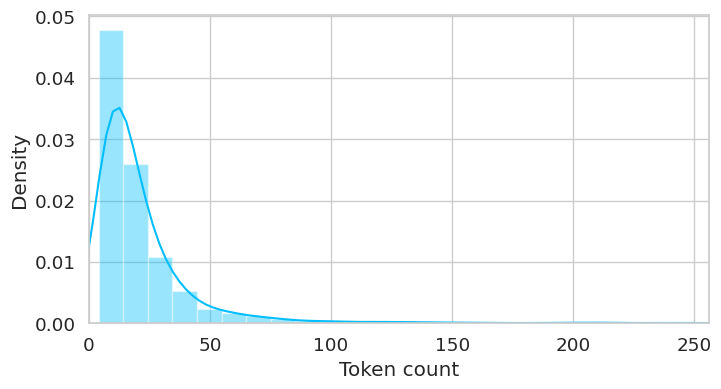

In [28]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review.
token_lens = []

for txt in df.cleanText:
    tokens = tokenizer.encode(txt,max_length=512) #each row contain fixed length of 512
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

# BERT MODEL

In [29]:
#split the data
df_train, df_test = train_test_split(df,test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print("train shape:",df_train.shape)
print("test shape:",df_test.shape)
print("val shape:",df_val.shape)

train shape: (5032, 2)
test shape: (630, 2)
val shape: (629, 2)


In [30]:
class_names = ['negative','positive']

In [31]:
#---------------------------Create dataset------------------------------------

MAX_LEN = 70

class SentimentClassifierDataset(Dataset):
    def __init__(self, text, targets2, tokenizer, max_len):
        self.text = text
        self.targets2 = targets2
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        target2 = self.targets2[index]

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'Headline_text':text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target2, dtype=torch.long)
                }

In [32]:
#--------------------------Create Data Loader-------------------------------

def create_data_loader2(df, tokenizer, max_len, batch_size):
    #create a instance of the SentimentClassifierDataset
    ds = SentimentClassifierDataset(
        text=df.cleanText.to_numpy(),
        targets2=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        ds,
        batch_size=batch_size)

BATCH_SIZE = 64

train_data_loader2 = create_data_loader2(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader2 = create_data_loader2(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader2 = create_data_loader2(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
#--------------------------------Building the model--------------------------------

#initialize the model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,return_dict=False)
        output = self.drop(pooled_output)
        return self.out(output)

model2 = SentimentClassifier(len(class_names))
#model = model.to(device)

In [34]:
#-----------------------------------Training----------------------------------

EPOCHS = 5

optimizer = AdamW(model2.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader2) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

# ----------------------------------Traning function------------------------------------
def train_epoch2(model2,
                data_loader,
                loss_fn,
                optimizer,
                scheduler,
                n_examples):

    model2 = model2.train() # model becoming in the training mode.

    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets = batch["targets"]

        outputs = model2(
          input_ids=input_ids,
          attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        #avoiding the exploiding gradiant
        nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [35]:
# ------------------------------Evaluation function-----------------------------------
def eval_model2(model2, data_loader, loss_fn, n_examples):

    model2 = model2.eval() # model becoming in the evaluation mode.(no dropout,batch norm apply)

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            targets = batch["targets"]

            outputs = model2(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)



In [ ]:
# starting the training process.
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 30)

    train_acc, train_loss = train_epoch2(
        model2,
        train_data_loader2,
        loss_fn,
        optimizer,
        scheduler,
        len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model2(
        model2,
        val_data_loader2,
        loss_fn,
        len(df_val))

    print(f'Val  loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/my_thesis/best_model_state_BAT.bin')
        best_accuracy = val_acc

Epoch 1/5
------------------------------
Train loss 0.6279131102411053 accuracy 0.6720985691573926
Val  loss 0.514282900094986 accuracy 0.7217806041335453

Epoch 2/5
------------------------------
Train loss 0.4080791769525673 accuracy 0.8233306836248012
Val  loss 0.5565174400806427 accuracy 0.7456279809220986

Epoch 3/5
------------------------------
